In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.0367

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 580ms/step - loss: 0.0246
Average validation loss: 0.7486630082130432
4/4 [==============================] - 5s 596ms/step - loss: 0.0246 - val_loss: 0.7487
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 580ms/step - loss: 0.0158 - val_loss: 0.7487
Average validation loss: 0.616234302520752
4/4 [==============================] - 7s 591ms/step - loss: 0.0158 - val_loss: 0.6824
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 583ms/step - loss: 0.0112 - val_loss: 0.6824
Average validation loss: 0.4927736222743988
4/4 [==============================] - 10s 596ms/step - loss: 0.0112 - val_loss:

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 698ms/step - loss: 5.4331e-07
Average validation loss: 0.021602087654173374
8/8 [==============================] - 6s 708ms/step - loss: 5.4331e-07 - val_loss: 0.0216
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 692ms/step - loss: 5.4524e-07 - val_loss: 0.0216
Average validation loss: 0.03592699579894543
8/8 [==============================] - 11s 703ms/step - loss: 5.4524e-07 - val_loss: 0.0288
Epoch 3/10
8/8 [==============================] - 17s 700ms/step - loss: 5.3756e-07 - val_loss: 0.0288
Average validation loss: 0.005624071229249239
8/8 [==============================] - 17s 712ms/step - loss: 5.3756e-07 - val_loss: 0.0211
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segfo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 725ms/step - loss: 2.7443e-06
Average validation loss: 0.030990249341508996
12/12 [==============================] - 9s 736ms/step - loss: 2.7443e-06 - val_loss: 0.0310
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 680ms/step - loss: 2.6457e-06 - val_loss: 0.0310
Average validation loss: 0.03317577401564146
12/12 [==============================] - 17s 693ms/step - loss: 2.6457e-06 - val_loss: 0.0321
Epoch 3/10
12/12 [==============================] - 25s 685ms/step - loss: 2.5229e-06 - val_loss: 0.0321
Average validation loss: 0.04312299821564617
12/12 [==============================] - 26s 698ms/step - loss: 2.5229e-06 - val_loss: 0.0358
Epoch 4/10
12/12 [==============================] - 34s 688ms/step - loss: 2.4861e-06 - val_loss: 0.0358
Average validation

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 730ms/step - loss: 2.2208e-06
Average validation loss: 0.08501198346493766
16/16 [==============================] - 12s 740ms/step - loss: 2.2208e-06 - val_loss: 0.0850
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 710ms/step - loss: 2.2154e-06 - val_loss: 0.0850
Average validation loss: 0.03922421613242477
16/16 [==============================] - 23s 721ms/step - loss: 2.2154e-06 - val_loss: 0.0621
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 713ms/step - loss: 2.0877e-06 - val_loss: 0.0621
Average validation loss: 0.0666070207953453
16/16 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 718ms/step - loss: 5.8923e-07
Average validation loss: 0.16464768648147582
20/20 [==============================] - 15s 728ms/step - loss: 5.8923e-07 - val_loss: 0.1646
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 700ms/step - loss: 5.4651e-07 - val_loss: 0.1646
Average validation loss: 0.06294352710247039
20/20 [==============================] - 29s 711ms/step - loss: 5.4651e-07 - val_loss: 0.1138
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 709ms/step - loss: 5.3371e-07 - val_loss: 0.1138
Average validation loss: 0.06765253245830535
20/20 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 719ms/step - loss: 7.3031e-07
Average validation loss: 0.16044547657171884
24/24 [==============================] - 17s 731ms/step - loss: 7.3031e-07 - val_loss: 0.1604
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 707ms/step - loss: 7.0248e-07 - val_loss: 0.1604
Average validation loss: 0.06920982586840789
24/24 [==============================] - 35s 718ms/step - loss: 7.0248e-07 - val_loss: 0.1148
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 51s 689ms/step - loss: 6.7708e-07 - val_loss: 0.1148
Average validation loss: 0.059075078616539635
24/24 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 710ms/step - loss: 1.3338e-06
Average validation loss: 0.2239638552069664
40/40 [==============================] - 29s 720ms/step - loss: 1.3338e-06 - val_loss: 0.2240
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 713ms/step - loss: 1.2314e-06 - val_loss: 0.2240
Average validation loss: 0.060213282518088815
40/40 [==============================] - 58s 723ms/step - loss: 1.2314e-06 - val_loss: 0.1421
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 86s 711ms/step - loss: 1.2328e-06 - val_loss: 0.1421
Average validation loss: 0.09427746683359146
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 705ms/step - loss: 1.1843e-06
Average validation loss: 0.05421805419609882
48/48 [==============================] - 34s 716ms/step - loss: 1.1843e-06 - val_loss: 0.0542
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 68s 709ms/step - loss: 9.2230e-07 - val_loss: 0.0542
Average validation loss: 0.039897027891129255
48/48 [==============================] - 69s 719ms/step - loss: 9.2230e-07 - val_loss: 0.0471
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 103s 708ms/step - loss: 7.7698e-07 - val_loss: 0.0471
Average validation loss: 0.04868808947503567
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 714ms/step - loss: 1.6781e-06
Average validation loss: 0.044776119225259335
56/56 [==============================] - 41s 725ms/step - loss: 1.6781e-06 - val_loss: 0.0448
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 713ms/step - loss: 1.1922e-06 - val_loss: 0.0448
Average validation loss: 0.052397317751975994
56/56 [==============================] - 81s 724ms/step - loss: 1.1922e-06 - val_loss: 0.0486
Epoch 3/10
56/56 [==============================] - 121s 718ms/step - loss: 9.0887e-07 - val_loss: 0.0486
Average validation loss: 0.04519486340827176
56/56 [==============================] - 122s 728ms/step - loss: 9.0887e-07 - val_loss: 0.0475
Epoch 4/10
56/56 [==============================] - 162s 706ms/step - loss: 7.2280e-07 - val_loss: 0.0475
Average vali

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 721ms/step - loss: 6.5222e-07
Average validation loss: 0.05392416781978682
64/64 [==============================] - 47s 732ms/step - loss: 6.5222e-07 - val_loss: 0.0539
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 709ms/step - loss: 4.4272e-07 - val_loss: 0.0539
Average validation loss: 0.037814009439898655
64/64 [==============================] - 93s 719ms/step - loss: 4.4272e-07 - val_loss: 0.0459
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 138s 707ms/step - loss: 3.3000e-07 - val_loss: 0.0459
Average validation loss: 0.031929763965308666
64/64 [==============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 713ms/step - loss: 6.4788e-07
Average validation loss: 0.042816177734898195
72/72 [==============================] - 52s 723ms/step - loss: 6.4788e-07 - val_loss: 0.0428
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 103s 706ms/step - loss: 4.4213e-07 - val_loss: 0.0428
Average validation loss: 0.03245038632303476
72/72 [==============================] - 104s 716ms/step - loss: 4.4213e-07 - val_loss: 0.0376
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 155s 714ms/step - loss: 3.2970e-07 - val_loss: 0.0376
Average validation loss: 0.037878528547783695
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 706ms/step - loss: 5.8445e-07
Average validation loss: 0.02331387922167778
80/80 [==============================] - 57s 716ms/step - loss: 5.8445e-07 - val_loss: 0.0233
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 711ms/step - loss: 3.6257e-07 - val_loss: 0.0233
Average validation loss: 0.027128733042627574
80/80 [==============================] - 115s 720ms/step - loss: 3.6257e-07 - val_loss: 0.0252
Epoch 3/10
80/80 [==============================] - 172s 708ms/step - loss: 2.7517e-07 - val_loss: 0.0252
Average validation loss: 0.03372257351875305
80/80 [==============================] - 172s 718ms/step - loss: 2.7517e-07 - val_loss: 0.0281
Epoch 4/10
80/80 [==============================] - 230s 713ms/step - loss: 2.2698e-07 - val_loss: 0.0281
Average va

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 712ms/step - loss: 2.1736e-06
Average validation loss: 0.05967942517600022
96/96 [==============================] - 69s 722ms/step - loss: 2.1736e-06 - val_loss: 0.0597
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 137s 708ms/step - loss: 1.3471e-06 - val_loss: 0.0597
Average validation loss: 0.056714925391133875
96/96 [==============================] - 138s 717ms/step - loss: 1.3471e-06 - val_loss: 0.0582
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 206s 708ms/step - loss: 9.8427e-07 - val_loss: 0.0582
Average validation loss: 0.06236890720902011
96/96 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 707ms/step - loss: 8.2772e-07
Average validation loss: 0.05130999417354663
120/120 [==============================] - 86s 717ms/step - loss: 8.2772e-07 - val_loss: 0.0513
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 706ms/step - loss: 4.9771e-07 - val_loss: 0.0513
Average validation loss: 0.034726790819937986
120/120 [==============================] - 172s 716ms/step - loss: 4.9771e-07 - val_loss: 0.0430
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 256s 701ms/step - loss: 3.6013e-07 - val_loss: 0.0430
Average validation loss: 0.04004380526021123
120/120 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 708ms/step - loss: 4.8792e-07
Average validation loss: 0.03436726133804768
144/144 [==============================] - 103s 717ms/step - loss: 4.8792e-07 - val_loss: 0.0344
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 206s 710ms/step - loss: 3.0902e-07 - val_loss: 0.0344
Average validation loss: 0.0361834159379618
144/144 [==============================] - 207s 719ms/step - loss: 3.0902e-07 - val_loss: 0.0353
Epoch 3/10
144/144 [==============================] - 309s 708ms/step - loss: 2.3368e-07 - val_loss: 0.0353
Average validation loss: 0.03465896944463667
144/144 [==============================] - 310s 718ms/step - loss: 2.3368e-07 - val_loss: 0.0351
Epoch 4/10
144/144 [==============================] - 412s 707ms/step - loss: 1.9166e-07 - val_loss: 0.0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 705ms/step - loss: 1.7395e-06
Average validation loss: 0.08409163253381849
160/160 [==============================] - 114s 715ms/step - loss: 1.7395e-06 - val_loss: 0.0841
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 706ms/step - loss: 1.6311e-06 - val_loss: 0.0841
Average validation loss: 0.09709379076957703
160/160 [==============================] - 229s 716ms/step - loss: 1.6311e-06 - val_loss: 0.0906
Epoch 3/10
160/160 [==============================] - 343s 710ms/step - loss: 1.6489e-06 - val_loss: 0.0906
Average validation loss: 1.262633389234543
160/160 [==============================] - 344s 720ms/step - loss: 1.6489e-06 - val_loss: 0.4813
Epoch 4/10
160/160 [==============================] - 457s 705ms/step - loss: 1.6537e-06 - val_loss: 0.48

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 707ms/step - loss: 1.3247e-06
Average validation loss: 0.04026367347687483
200/200 [==============================] - 143s 717ms/step - loss: 1.3247e-06 - val_loss: 0.0403
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 285s 707ms/step - loss: 1.3325e-06 - val_loss: 0.0403
Average validation loss: 0.03998301263898611
200/200 [==============================] - 287s 717ms/step - loss: 1.3325e-06 - val_loss: 0.0401
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 429s 709ms/step - loss: 1.2846e-06 - val_loss: 0.0401
Average validation loss: 0.4507791888713837
200/200 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:04 - loss: 6.5294e-07

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 170s 708ms/step - loss: 6.5657e-07
Average validation loss: 0.027416705749055838
240/240 [==============================] - 172s 718ms/step - loss: 6.5657e-07 - val_loss: 0.0274
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 342s 707ms/step - loss: 5.5819e-07 - val_loss: 0.0274
Average validation loss: 0.04108511321246624
240/240 [==============================] - 344s 717ms/step - loss: 5.5819e-07 - val_loss: 0.0343
Epoch 3/10
240/240 [==============================] - 514s 708ms/step - loss: 5.3246e-07 - val_loss: 0.0343
Average validation loss: 0.05188152861470977
240/240 [==============================] - 517s 718ms/step - loss: 5.3246e-07 - val_loss: 0.0401
Epoch 4/10
240/240 [==============================] - 687s 710ms/step - loss: 5.1095e-07 - val_loss: 0

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1299248410249129, 0.03298445994383656, 0.06702481471040907, 0.09103279291199215, 0.07932583994418382, 0.06531372921696554, 0.06794376127514987, 0.0414005316644519, 0.039549715357965656, 0.03427458787104115, 0.027795912912115455, 0.025484497604949863, 0.042232190210197584, 0.03528011807550987, 0.10843852851769446, 0.089261264202476, 0.04965415138667449, 0.03489886932306884]
std_val_losses =  [0.18103684307767579, 0.0158538545489051, 0.03109642070469835, 0.07459425281570924, 0.0235239896222484, 0.02594083099474165, 0.04134035295701101, 0.008452962197539497, 0.010094315186604022, 0.007546664603311517, 0.006426677854112494, 0.0059315457791851356, 0.010636302713256782, 0.007155075960539233, 0.15171358274165644, 0.19562387252560695, 0.058851796714474235, 0.02129466955698086]


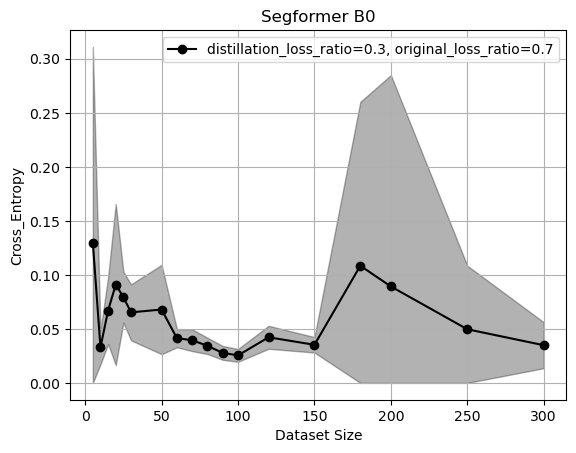

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()